In [0]:
from PIL import Image
import matplotlib.pyplot as plt 
import numpy as np
import time

import torch
import torch.nn as nn
import torch.optim as optim
import torchvision
from torchvision import transforms, models

IN_MOMENTUM = 0.1

In [8]:
from google.colab import drive
drive.mount('/content/gdrive')

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


In [9]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)

cuda


In [0]:
class ReflectionConv(nn.Module):
    '''
        Reflection padding convolution
    '''
    def __init__(self, in_channels, out_channels, kernel_size, stride):
        super(ReflectionConv, self).__init__()
        reflection_padding = int(np.floor(kernel_size / 2))
        self.reflection_pad = nn.ReflectionPad2d(reflection_padding)
        self.conv = nn.Conv2d(in_channels, out_channels, kernel_size, stride)
    
    def forward(self, x):
        out = self.reflection_pad(x)
        out = self.conv(out)
        return out


class ConvLayer(nn.Module):
    '''
        zero-padding convolution
    '''
    def __init__(self, in_channels, out_channels, kernel_size, stride):
        super(ConvLayer, self).__init__()
        conv_padding = int(np.floor(kernel_size / 2))
        self.conv = nn.Conv2d(in_channels, out_channels, kernel_size, stride, padding=conv_padding)
    def forward(self, x):
        return self.conv(x)
  

class BasicBlock(nn.Module):
    def __init__(self, in_channels, out_channels, kernel_size, stride):
        super(BasicBlock, self).__init__()
        self.in_channels = in_channels
        self.out_channels = out_channels
        self.relu = nn.ReLU(inplace=True) # 1

        self.identity_block = nn.Sequential(
            ConvLayer(in_channels, out_channels // 4, kernel_size=1, stride=1),
            nn.InstanceNorm2d(out_channels // 4, momentum=IN_MOMENTUM),
            nn.ReLU(),
            ConvLayer(out_channels // 4, out_channels // 4, kernel_size, stride=stride),
            nn.InstanceNorm2d(out_channels // 4, momentum=IN_MOMENTUM),
            nn.ReLU(),
            ConvLayer(out_channels // 4, out_channels, kernel_size=1, stride=1),
            nn.InstanceNorm2d(out_channels, momentum=IN_MOMENTUM),
            nn.ReLU(),
        )
        self.shortcut = nn.Sequential(
            ConvLayer(in_channels, out_channels, 1, stride),
            nn.InstanceNorm2d(out_channels)
        )
    
    def forward(self, x):
        out = self.identity_block(x)
        if self.in_channels == self.out_channels:
            residual = x
        else: 
            residual = self.shortcut(x)
        out += residual
        out = self.relu(out)

        return out


class Upsample(nn.Module):
    '''
        Since the number of channels of the feature map changes after upsampling in HRNet.
        we have to write a new Upsample class.
    '''
    def __init__(self, in_channels, out_channels, scale_factor, mode):
        super(Upsample, self).__init__()
        self.conv = nn.Conv2d(in_channels, out_channels, kernel_size=3, stride=2, padding=1)
        self.upsample = nn.Upsample(scale_factor=scale_factor, mode='nearest')
        self.instance = nn.InstanceNorm2d(out_channels)
        self.relu = nn.ReLU(inplace=True)

    def forward(self, x):
        out = self.conv(x)
        out = self.upsample(out)
        out = self.instance(out)
        out = self.relu(out)
        
        return out


class HRNet(nn.Module):
    def __init__(self):
        super(HRNet, self).__init__()

        self.pass1_1 = BasicBlock(3, 16, kernel_size=3, stride=1)
        self.pass1_2 = BasicBlock(16, 32, kernel_size=3, stride=1)
        self.pass1_3 = BasicBlock(32, 32, kernel_size=3, stride=1)
        self.pass1_4 = BasicBlock(64, 64, kernel_size=3, stride=1)
        self.pass1_5 = BasicBlock(192, 64, kernel_size=3, stride=1)
        self.pass1_6 = BasicBlock(64, 32, kernel_size=3, stride=1)
        self.pass1_7 = BasicBlock(32, 16, kernel_size=3, stride=1)
        self.pass1_8 = nn.Conv2d(16, 3, kernel_size=3, stride=1, padding=1)
        self.pass2_1 = BasicBlock(32, 32, kernel_size=3, stride=1)
        self.pass2_2 = BasicBlock(64, 64, kernel_size=3, stride=1)
        
        self.downsample1_1 = nn.Conv2d(16, 32, kernel_size=3, stride=2, padding=1)
        self.downsample1_2 = nn.Conv2d(32, 32, kernel_size=3, stride=2, padding=1)
        self.downsample1_3 = nn.Conv2d(64, 64, kernel_size=3, stride=2, padding=1)
        self.downsample1_4 = nn.Conv2d(32, 32, kernel_size=3, stride=4, padding=1)
        self.downsample1_5 = nn.Conv2d(64, 64, kernel_size=3, stride=4, padding=1)
        self.downsample2_1 = nn.Conv2d(32, 32, kernel_size=3, stride=2, padding=1)
        self.downsample2_2 = nn.Conv2d(64, 64, kernel_size=3, stride=2, padding=1)

        self.upsample1_1 = nn.Upsample(scale_factor=2, mode='bilinear')
        self.upsample1_2 = nn.Upsample(scale_factor=2, mode='bilinear')
        self.upsample2_1 = nn.Upsample(scale_factor=4, mode='bilinear')
        self.upsample2_2 = nn.Upsample(scale_factor=2, mode='bilinear')

    def forward(self, x):
        map1 = self.pass1_1(x)
        map2 = self.pass1_2(map1)
        map3 = self.downsample1_1(map1)
        map4 = torch.cat((self.pass1_3(map2), self.upsample1_1(map3)), 1)
        map5 = torch.cat((self.downsample1_2(map2), self.pass2_1(map3)), 1)
        map6 = torch.cat((self.downsample1_4(map2), self.downsample2_1(map3)), 1)
        map7 = torch.cat((self.pass1_4(map4), self.upsample1_2(map5), self.upsample2_1(map6)), 1)
        out = self.pass1_5(map7)
        out = self.pass1_6(out)
        out = self.pass1_7(out)
        out = self.pass1_8(out)

        return out

In [0]:
def load_image(img_path, img_size=None):
    '''
        Resize the input image so we can make content image and style image have same size, 
        change image into tensor and normalize it
    '''
    
    image = Image.open(img_path)
    if img_size is not None:
        image = image.resize((img_size, img_size))  # change image size to (3, img_size, img_size)
    
    transform = transforms.Compose([
                        # convert the (H x W x C) PIL image in the range(0, 255) into (C x H x W) tensor in the range(0.0, 1.0) 
                        transforms.ToTensor(),
                        transforms.Normalize((0.485, 0.456, 0.406), (0.229, 0.224, 0.225)),   # this is from ImageNet dataset
                        ])   

    # change image's size to (b, 3, h, w)
    image = transform(image)[:3, :, :].unsqueeze(0)

    return image


def im_convert(tensor):
    """ Display a tensor as an image. """

    image = tensor.to("cpu").clone().detach()
    image = image.numpy().squeeze(0)    # change size to (channel, height, width)

    '''
        tensor (batch, channel, height, width)
        numpy.array (height, width, channel)
        to transform tensor to numpy, tensor.transpose(1,2,0) 
    '''
    image = image.transpose(1,2,0)
    image = image * np.array((0.229, 0.224, 0.225)) + np.array((0.485, 0.456, 0.406))   # change into unnormalized image
    image = image.clip(0, 1)    # in the previous steps, we change PIL image(0, 255) into tensor(0.0, 1.0), so convert it

    return image


def get_features(image, model, layers=None):
    '''
        return a dictionary consists of each layer's name and it's feature maps
    '''
    if layers is None:
        layers = {'0': 'conv1_1',   # default style layer
                  '5': 'conv2_1',   # default style layer
                  '10': 'conv3_1',  # default style layer
                  '19': 'conv4_1',  # default style layer
                  '21': 'conv4_2',  # default content layer
                  '28': 'conv5_1'}  # default style layer
    features = {}
    x = image
    # model._modules is a dictionary holding each module in the model
    for name, layer in model._modules.items():
        x = layer(x)    #  layer(x) is the feature map through the layer when the input is x
        if name in layers:
            features[layers[name]] = x
    
    return features


def get_grim_matrix(tensor):
    b, c, h, w = tensor.size()
    tensor = tensor.view(b * c, h * w)
    gram_matrix = torch.mm(tensor, tensor.t())
    return gram_matrix

In [12]:
# get the VGG19's structure except the full-connect layers
VGG = models.vgg19(pretrained=True).features
print(VGG)
# only use VGG19 to extract features, we don't need to change it's parameters
for parameter in VGG.parameters():
    parameter.requires_grad_(False)

Sequential(
  (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (1): ReLU(inplace=True)
  (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (3): ReLU(inplace=True)
  (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (6): ReLU(inplace=True)
  (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (8): ReLU(inplace=True)
  (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (11): ReLU(inplace=True)
  (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (13): ReLU(inplace=True)
  (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (15): ReLU(inplace=True)
  (16): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (17): ReLU(inplace=True)
  (18): MaxPoo

In [13]:
style_net = HRNet()
print(style_net)

HRNet(
  (pass1_1): BasicBlock(
    (relu): ReLU(inplace=True)
    (identity_block): Sequential(
      (0): ConvLayer(
        (conv): Conv2d(3, 4, kernel_size=(1, 1), stride=(1, 1))
      )
      (1): InstanceNorm2d(4, eps=1e-05, momentum=0.1, affine=False, track_running_stats=False)
      (2): ReLU()
      (3): ConvLayer(
        (conv): Conv2d(4, 4, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      )
      (4): InstanceNorm2d(4, eps=1e-05, momentum=0.1, affine=False, track_running_stats=False)
      (5): ReLU()
      (6): ConvLayer(
        (conv): Conv2d(4, 16, kernel_size=(1, 1), stride=(1, 1))
      )
      (7): InstanceNorm2d(16, eps=1e-05, momentum=0.1, affine=False, track_running_stats=False)
      (8): ReLU()
    )
    (shortcut): Sequential(
      (0): ConvLayer(
        (conv): Conv2d(3, 16, kernel_size=(1, 1), stride=(1, 1))
      )
      (1): InstanceNorm2d(16, eps=1e-05, momentum=0.1, affine=False, track_running_stats=False)
    )
  )
  (pass1_2): BasicBlock(
    

In [0]:
content_image = load_image("/content/gdrive/My Drive/contentsf.png")

style_image = load_image("/content/gdrive/My Drive/stylesf.png")


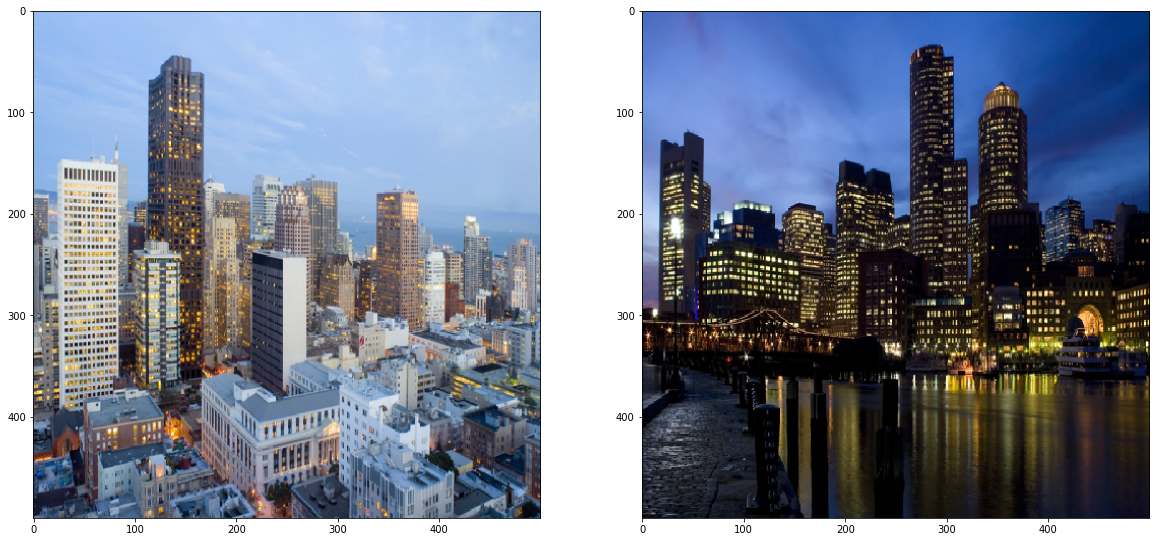

In [15]:
# display the raw images
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(20, 10))
# content and style ims side-by-side
ax1.imshow(im_convert(content_image))
ax2.imshow(im_convert(style_image))
plt.show()

In [0]:
content_features = get_features(content_image, VGG)
style_features   = get_features(style_image, VGG)

style_gram_matrixs = {layer: get_grim_matrix(style_features[layer]) for layer in style_features}

target = content_image.clone().requires_grad_(True)

In [0]:
# try to give fore con_layers more weight so that can get more detail in output iamge
style_weights = {'conv1_1': 0.1,
                 'conv2_1': 0.2,
                 'conv3_1': 0.4,
                 'conv4_1': 0.8,
                 'conv5_1': 1.6}

content_weight = 150
style_weight = 1

show_every = 100
optimizer = optim.Adam(style_net.parameters(), lr=5e-3)
scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=200, gamma=0.9)
steps = 1000

content_loss_epoch = []
style_loss_epoch = []
total_loss_epoch = []
output_image = content_image

/usr/local/lib/python3.6/dist-packages/torch/optim/lr_scheduler.py:122: UserWarning: Detected call of `lr_scheduler.step()` before `optimizer.step()`. In PyTorch 1.1.0 and later, you should call them in the opposite order: `optimizer.step()` before `lr_scheduler.step()`.  Failure to do this will result in PyTorch skipping the first value of the learning rate schedule. See more details at https://pytorch.org/docs/stable/optim.html#how-to-adjust-learning-rate
  "https://pytorch.org/docs/stable/optim.html#how-to-adjust-learning-rate", UserWarning)
/usr/local/lib/python3.6/dist-packages/torch/nn/functional.py:2506: UserWarning: Default upsampling behavior when mode=bilinear is changed to align_corners=False since 0.4.0. Please specify align_corners=True if the old behavior is desired. See the documentation of nn.Upsample for details.
  "See the documentation of nn.Upsample for details.".format(mode))


After 0 criterions:
Total loss:  3440.9306640625
Content loss:  15.077431678771973
Style loss:  1179.3157958984375


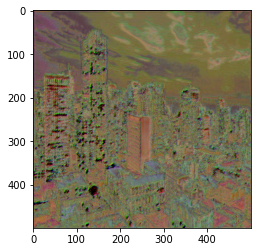

After 5 criterions:
Total loss:  1849.537109375
Content loss:  9.460600852966309
Style loss:  430.4469909667969


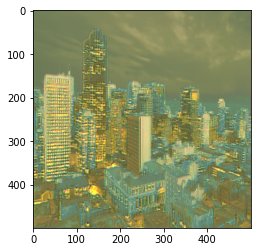

After 10 criterions:
Total loss:  1464.1414794921875
Content loss:  7.745400905609131
Style loss:  302.3313293457031


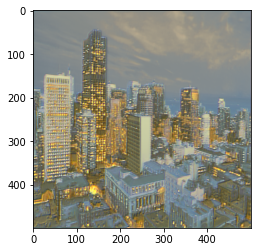

After 15 criterions:
Total loss:  1168.099365234375
Content loss:  6.121901988983154
Style loss:  249.81414794921875


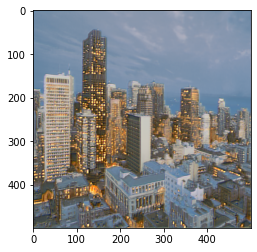

After 20 criterions:
Total loss:  965.0631713867188
Content loss:  4.886357307434082
Style loss:  232.10955810546875


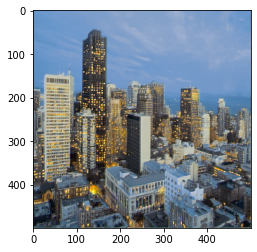

After 25 criterions:
Total loss:  837.7597045898438
Content loss:  4.224943161010742
Style loss:  204.0182342529297


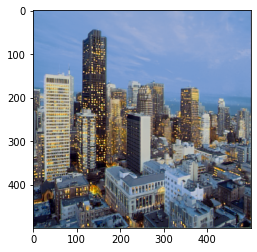

After 30 criterions:
Total loss:  738.5094604492188
Content loss:  3.5539212226867676
Style loss:  205.4212646484375


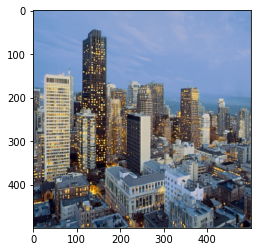

After 35 criterions:
Total loss:  656.5850830078125
Content loss:  3.032857656478882
Style loss:  201.65643310546875


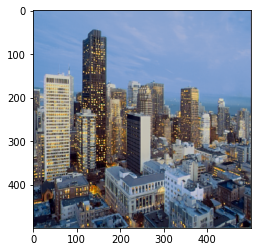

After 40 criterions:
Total loss:  595.1785888671875
Content loss:  2.6310312747955322
Style loss:  200.52386474609375


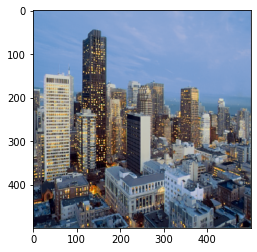

After 45 criterions:
Total loss:  545.2728271484375
Content loss:  2.316610097885132
Style loss:  197.78128051757812


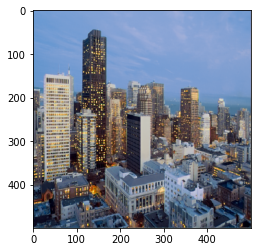

After 50 criterions:
Total loss:  508.117919921875
Content loss:  2.0514655113220215
Style loss:  200.3981170654297


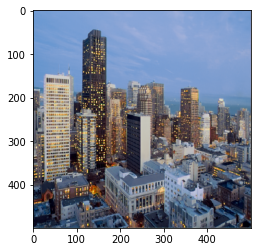

After 55 criterions:
Total loss:  473.4613037109375
Content loss:  1.8297570943832397
Style loss:  198.9977569580078


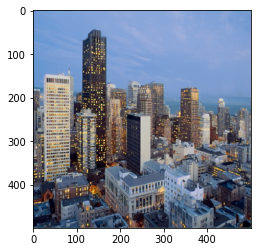

After 60 criterions:
Total loss:  454.0522155761719
Content loss:  1.7113419771194458
Style loss:  197.35092163085938


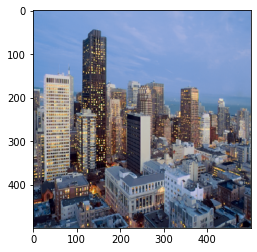

After 65 criterions:
Total loss:  450.170654296875
Content loss:  1.72001314163208
Style loss:  192.1686553955078


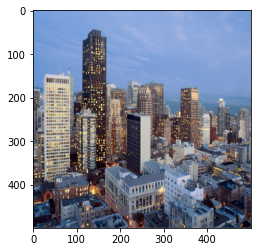

After 70 criterions:
Total loss:  423.3856201171875
Content loss:  1.5549051761627197
Style loss:  190.1498565673828


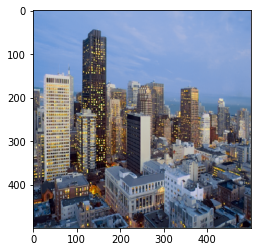

After 75 criterions:
Total loss:  410.78631591796875
Content loss:  1.432021141052246
Style loss:  195.98313903808594


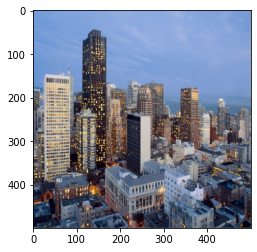

After 80 criterions:
Total loss:  396.64019775390625
Content loss:  1.321926236152649
Style loss:  198.35125732421875


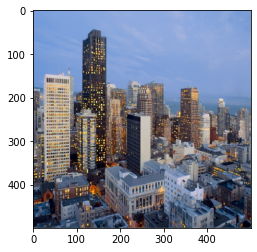

After 85 criterions:
Total loss:  380.76220703125
Content loss:  1.2427114248275757
Style loss:  194.35549926757812


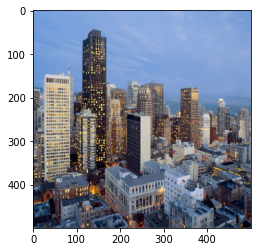

After 90 criterions:
Total loss:  368.62652587890625
Content loss:  1.2150474786758423
Style loss:  186.36940002441406


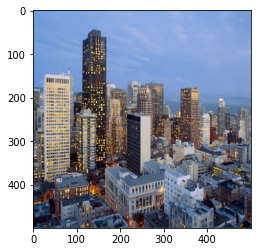

After 95 criterions:
Total loss:  364.8822021484375
Content loss:  1.1635297536849976
Style loss:  190.3527374267578


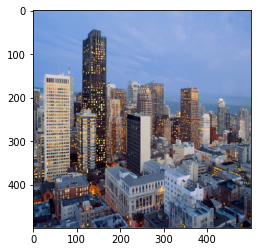

After 100 criterions:
Total loss:  356.97198486328125
Content loss:  1.1638983488082886
Style loss:  182.3872528076172


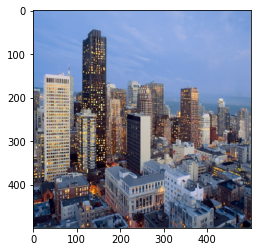

After 105 criterions:
Total loss:  352.85205078125
Content loss:  1.1212908029556274
Style loss:  184.658447265625


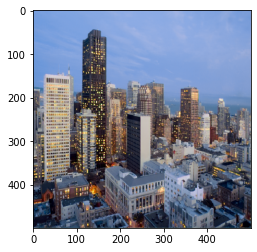

After 110 criterions:
Total loss:  358.6407470703125
Content loss:  1.1327109336853027
Style loss:  188.73411560058594


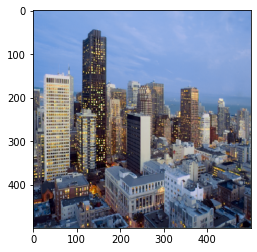

After 115 criterions:
Total loss:  333.80535888671875
Content loss:  1.0362967252731323
Style loss:  178.36083984375


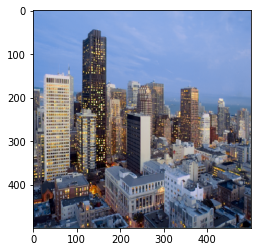

After 120 criterions:
Total loss:  331.8233947753906
Content loss:  1.042773962020874
Style loss:  175.4073028564453


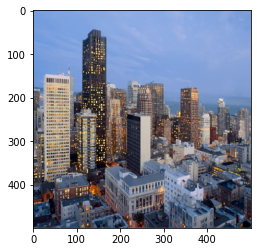

After 125 criterions:
Total loss:  327.98236083984375
Content loss:  0.9759752750396729
Style loss:  181.5860595703125


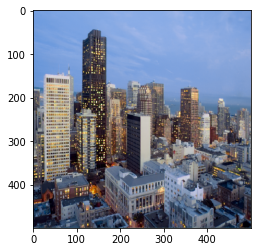

After 130 criterions:
Total loss:  316.4388427734375
Content loss:  1.0265445709228516
Style loss:  162.45713806152344


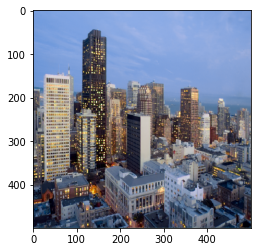

After 135 criterions:
Total loss:  317.84564208984375
Content loss:  0.9618488550186157
Style loss:  173.56829833984375


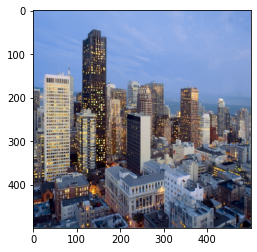

After 140 criterions:
Total loss:  314.49859619140625
Content loss:  1.0174822807312012
Style loss:  161.8762664794922


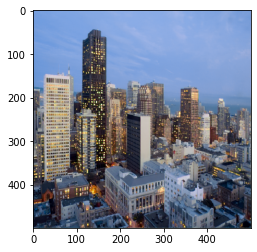

After 145 criterions:
Total loss:  343.4093017578125
Content loss:  0.9233477115631104
Style loss:  204.90713500976562


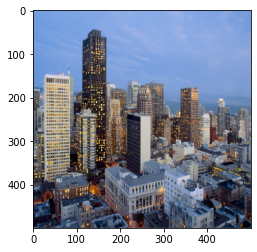

After 150 criterions:
Total loss:  322.6533508300781
Content loss:  1.137009859085083
Style loss:  152.10186767578125


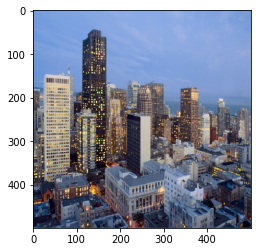

After 155 criterions:
Total loss:  308.7394104003906
Content loss:  0.9912431836128235
Style loss:  160.0529327392578


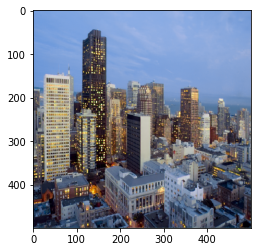

After 160 criterions:
Total loss:  306.75604248046875
Content loss:  0.9733694195747375
Style loss:  160.75064086914062


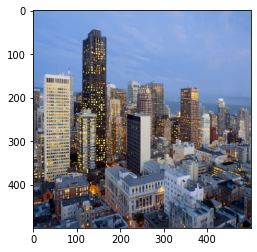

After 165 criterions:
Total loss:  296.7884521484375
Content loss:  0.9238928556442261
Style loss:  158.20452880859375


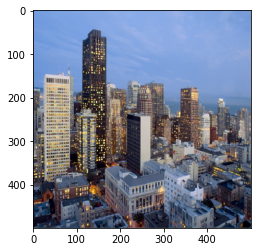

After 170 criterions:
Total loss:  291.2785339355469
Content loss:  0.82259601354599
Style loss:  167.88912963867188


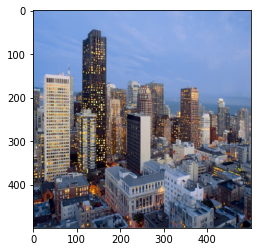

After 175 criterions:
Total loss:  286.57330322265625
Content loss:  0.872230589389801
Style loss:  155.7387237548828


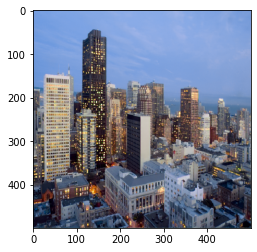

After 180 criterions:
Total loss:  285.10626220703125
Content loss:  0.880546510219574
Style loss:  153.02427673339844


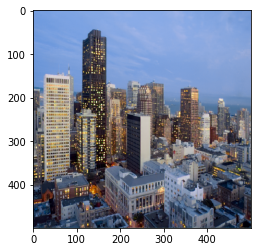

After 185 criterions:
Total loss:  306.72174072265625
Content loss:  1.1076288223266602
Style loss:  140.5774383544922


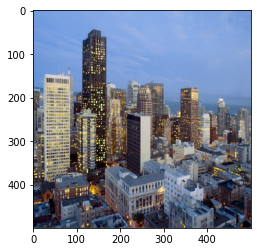

After 190 criterions:
Total loss:  286.12835693359375
Content loss:  0.9451034069061279
Style loss:  144.3628387451172


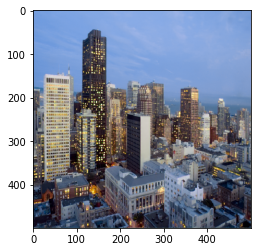

After 195 criterions:
Total loss:  281.005126953125
Content loss:  0.8159587383270264
Style loss:  158.61131286621094


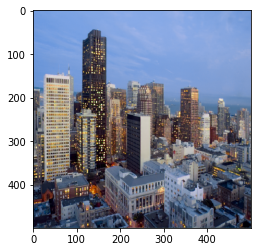

After 200 criterions:
Total loss:  279.144287109375
Content loss:  0.8071610927581787
Style loss:  158.07012939453125


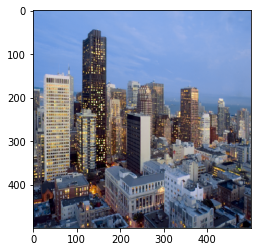

After 205 criterions:
Total loss:  272.408203125
Content loss:  0.8248891830444336
Style loss:  148.67481994628906


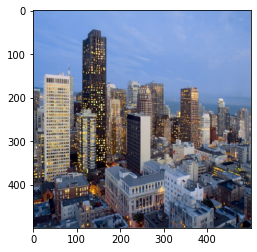

After 210 criterions:
Total loss:  270.08465576171875
Content loss:  0.7900141477584839
Style loss:  151.58251953125


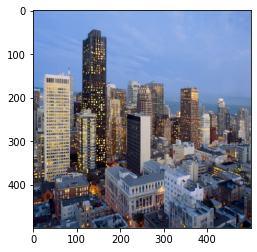

After 215 criterions:
Total loss:  268.911865234375
Content loss:  0.8093662261962891
Style loss:  147.50692749023438


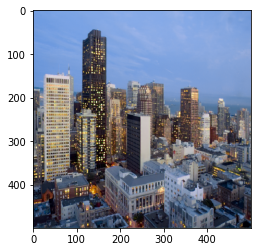

After 220 criterions:
Total loss:  278.0382080078125
Content loss:  0.7504436373710632
Style loss:  165.4716796875


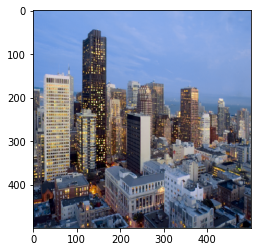

After 225 criterions:
Total loss:  266.5472717285156
Content loss:  0.7463011741638184
Style loss:  154.6020965576172


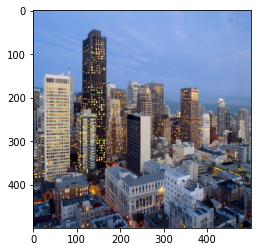

After 230 criterions:
Total loss:  261.82171630859375
Content loss:  0.7247300744056702
Style loss:  153.11221313476562


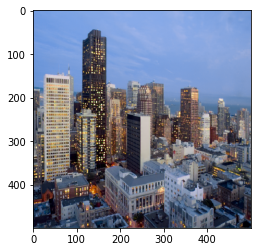

After 235 criterions:
Total loss:  264.3340148925781
Content loss:  0.7985104322433472
Style loss:  144.5574493408203


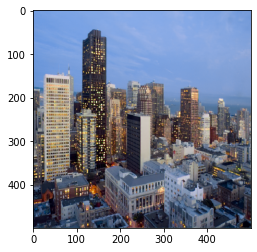

After 240 criterions:
Total loss:  262.87152099609375
Content loss:  0.7889603972434998
Style loss:  144.52745056152344


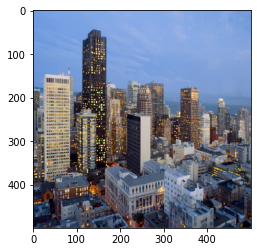

After 245 criterions:
Total loss:  262.92437744140625
Content loss:  0.7491292953491211
Style loss:  150.5549774169922


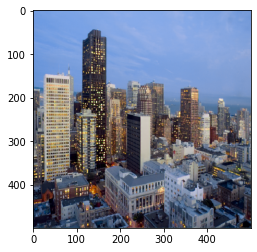

After 250 criterions:
Total loss:  258.7766418457031
Content loss:  0.7156005501747131
Style loss:  151.43655395507812


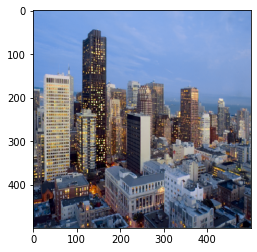

After 255 criterions:
Total loss:  254.43179321289062
Content loss:  0.7512849569320679
Style loss:  141.7390594482422


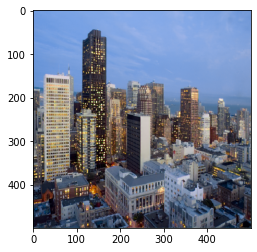

After 260 criterions:
Total loss:  266.2304992675781
Content loss:  0.7250002026557922
Style loss:  157.48046875


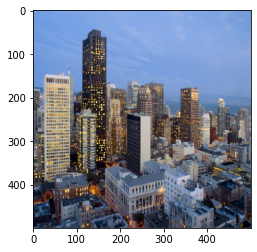

After 265 criterions:
Total loss:  280.814697265625
Content loss:  0.6877665519714355
Style loss:  177.6497039794922


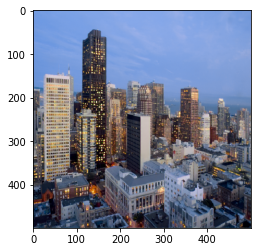

After 270 criterions:
Total loss:  269.07269287109375
Content loss:  0.7839125394821167
Style loss:  151.48580932617188


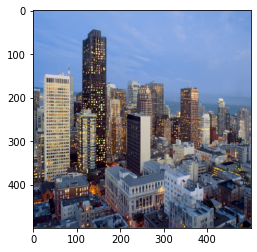

After 275 criterions:
Total loss:  259.82073974609375
Content loss:  0.7637377977371216
Style loss:  145.26007080078125


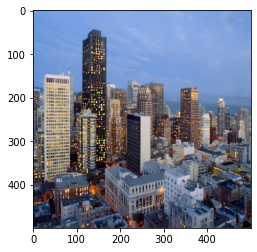

After 280 criterions:
Total loss:  254.007568359375
Content loss:  0.7216856479644775
Style loss:  145.75473022460938


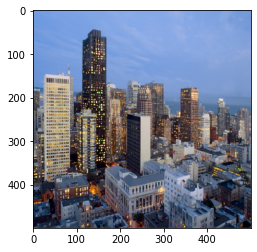

KeyboardInterrupt: ignored

In [18]:
time_start=time.time()
for epoch in range(0, steps+1):
    
    scheduler.step()

    target = style_net(content_image)
    target.requires_grad_(True)


    target_features = get_features(target, VGG)  # extract output image's all feature maps
    content_loss = torch.mean((target_features['conv4_2'] - content_features['conv4_2']) ** 2)
    
    style_loss = 0

    # compute each layer's style loss and add them
    for layer in style_weights:
        
        target_feature = target_features[layer]  # output image's feature map after layer
        target_gram_matrix = get_grim_matrix(target_feature)
        style_gram_matrix = style_gram_matrixs[layer]

        layer_style_loss = style_weights[layer] * torch.mean((target_gram_matrix - style_gram_matrix) ** 2)
        b, c, h, w = target_feature.shape
        style_loss += layer_style_loss / (c * h * w)
    

    total_loss = content_weight * content_loss + style_weight * style_loss
    total_loss_epoch.append(total_loss)

    style_loss_epoch.append(style_weight * style_loss)
    content_loss_epoch.append(content_weight * content_loss)

    optimizer.zero_grad()
    total_loss.backward()
    optimizer.step()

    if epoch % 5 == 0:
        print("After %d criterions:" % epoch)
        print('Total loss: ', total_loss.item())
        print('Content loss: ', content_loss.item())
        print('Style loss: ', style_loss.item())
        plt.imshow(im_convert(target))
        plt.show()

    output_image = target
time_end=time.time()
print('totally cost', time_end - time_start)

In [0]:
# plot the line chart
epoch = range(0, steps + 1)
fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(20, 10))                                                       

ax1.plot(epoch, total_loss_epoch)
ax1.set_title("Total loss")
ax1.set_xlabel("epoch")
ax1.set_ylabel("Total loss")

ax2.plot(epoch, style_loss_epoch)
ax2.set_title("Style loss")
ax2.set_xlabel("epoch")
ax2.set_ylabel("Style loss")

ax3.plot(epoch, content_loss_epoch)
ax3.set_title("Content loss")
ax3.set_xlabel("epoch")
ax3.set_ylabel("Content loss")


plt.show()

In [0]:
# display the raw images
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(20, 10))
# content and style ims side-by-side
ax1.imshow(utils.im_convert(content_image))
ax2.imshow(utils.im_convert(output_image))
plt.show()